In [1]:
# Libraries
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.Align import substitution_matrices
from Bio.Align import substitution_matrices
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Flatten, Conv1D
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Data Files
from blosum62 import BLOSUM62_MATRIX
from grantham_distance import GRANTHAM_DISTANCE_MATRIX

print("All libraries and data files are successfully imported!")

All libraries and data files are successfully imported!


In [2]:
# Step 1: A function to read and extract sequences from a .fna file
def read_fna(file_path):
    sequence = ''
    with open(file_path, 'r') as file:
        next(file) 
        for line in file:
            line = line.strip()
            if line: 
                sequence += line
    return sequence

In [3]:
# Step 2: A functions to calculate the BLOSUM62 score and Grantham distance between sequences
blosum62 = substitution_matrices.load("BLOSUM62")

def calculate_blosum62(sequence, reference_sequence):
    score = 0
    
    for aa1, aa2 in zip(sequence, reference_sequence):
        score += blosum62.get((aa1, aa2), 0)
    return score

def calculate_grantham_distance(original_seq, mutated_seq):
    distance = 0
    for o, m in zip(original_seq, mutated_seq):
        if o in GRANTHAM_DISTANCE_MATRIX and m in GRANTHAM_DISTANCE_MATRIX[o]:
            distance += GRANTHAM_DISTANCE_MATRIX[o][m]
    return distance

In [4]:
# Step 3: A function to extract features from original and mutated sequences
def extract_features(original_seq, mutated_seq):
    features = {
        'original_sequence': original_seq,
        'BLOSUM62': calculate_blosum62(original_seq, mutated_seq),
        'Grantham Distance': calculate_grantham_distance(original_seq, mutated_seq)
    }
    return features

In [5]:
# Step 4: A function to calculate the final weight based on feature contributions
def calculate_final_weight(features):
    weights = {
        'BLOSUM62': 0.3,
        'Grantham Distance': 0.2,
        'Biochemical Change': 0.15,
        'Conservation': 0.1,
        'Structural Importance': 0.15,
        'Pathogenicity': 0.1
    }
    final_weight = sum(weights[key] * features.get(key, 0) for key in weights)
    return final_weight

In [6]:
# Step 5: A function to calculate the mutation score based on feature weights
def calculate_mutation_score(features):
    weights = {
        'BLOSUM62': 0.3,                 
        'Grantham Distance': 0.2,        
        'Biochemical Change': 0.15,     
        'Conservation': 0.1,             
        'Structural Importance': 0.15,   
        'Pathogenicity': 0.1
    }
    final_score = sum(weights[key] * features.get(key, 0) for key in weights)
    return final_score

In [7]:
# Step 6: A function to calculate the pathogenicity score based on multiple weighted factors
def calculate_pathogenicity(benign_pathogenic, conservation_score, structural_importance, mutation_percentage):
    weights = {
        'benign_pathogenic': 0.4,  
        'conservation_score': 0.2,  
        'structural_importance': 0.2,  
        'mutation_percentage': 0.2  
    }

    mutation_percentage_normalized = 100 - mutation_percentage  

    pathogenicity_score = (
        weights['benign_pathogenic'] * benign_pathogenic +
        weights['conservation_score'] * conservation_score +
        weights['structural_importance'] * structural_importance +
        weights['mutation_percentage'] * (mutation_percentage_normalized / 100)
    )

    return pathogenicity_score

In [8]:
# Step 7: A function to map and extract features from mutated sequence files and calculate final weights
def map_and_extract(original_seq, mutated_seq_files):
    results = []
    for mutated_file in mutated_seq_files:
        mutated_seq = read_fna(mutated_file)
        features = extract_features(original_seq, mutated_seq)
        features['Final Weight'] = calculate_final_weight(features)
        features['original_sequence'] = original_seq 
        results.append(features)
    return results

In [9]:
# Step 8: A functions to read sequences, load data, prepare it for LSTM, and train the model
def read_sequence_from_fna(file_path):
    with open(file_path, 'r') as file:
        next(file)  
        sequence = ''.join(line.strip() for line in file)  
    return sequence

def load_data(file_paths):
    X = []  # Features
    y = []  # Labels
    for file_path in file_paths:
        sequence = read_sequence_from_fna(file_path)
        X.append(sequence)
        y.append(1 if 'mutated' in file_path else 0)  
    return X, y

def create_char_to_int_mapping():
    chars = set('ACGT')
    char_to_int = {char: idx for idx, char in enumerate(chars)}
    return char_to_int

def prepare_data_for_lstm(X, y, char_to_int):
    int_data = []
    for seq in X:
        int_seq = [char_to_int.get(char, 0) for char in seq]  
        int_data.append(int_seq)

    print("Mapped int_data:", int_data)

    if not int_data or all(len(seq) == 0 for seq in int_data):
        raise ValueError("All sequences are empty or contain only unmapped characters.")

    max_length = max(len(seq) for seq in int_data)
    int_data = pad_sequences(int_data, maxlen=max_length, padding='post')

    y = np.array(y)

    return np.array(int_data), y

def train_lstm(X, y):
    X, y = prepare_data_for_lstm(X, y, create_char_to_int_mapping())
    
    print("Shape of X:", X.shape)  

    if len(X.shape) == 2: 
        X = np.expand_dims(X, axis=1)
    elif len(X.shape) != 3:
        raise ValueError("Input X must have shape (samples, timesteps, features)")

    model = Sequential()
    model.add(LSTM(50, input_shape=(X.shape[1], X.shape[2]))) 
    model.add(Dense(1, activation='sigmoid')) 
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    model.fit(X, y, epochs=10, batch_size=32, verbose=1)  
    return model

In [10]:

def prepare_data_for_cnn(data):
    sequences = [features['original_sequence'] for features in data]
    sequences = [''.join(seq) for seq in sequences]

    amino_acid_to_int = {aa: idx for idx, aa in enumerate(sorted(set(''.join(sequences))))}

    int_data = [[amino_acid_to_int[aa] for aa in seq] for seq in sequences]
    
    max_length = max(len(seq) for seq in int_data)
    padded_data = np.array([np.pad(seq, (0, max_length - len(seq)), 'constant') for seq in int_data])

    X = padded_data.reshape(padded_data.shape[0], padded_data.shape[1], 1)  
    
    y = np.array([features.get('Target', 0) for features in data]) 

    return X, y

In [11]:
def train_cnn(X_train, y_train):
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))  
    model.add(Dense(1))  
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=20, batch_size=64)
    return model

In [12]:
def calculate_scores_for_file(file_path, reference_sequence):
    scores = {}
    for record in SeqIO.parse(file_path, "fasta"):
        sequence = record.seq
        score = calculate_blosum62(sequence, reference_sequence)
        scores[record.id] = score
    return scores

In [13]:
def process_directory(directory_path, reference_sequence):
    all_scores = {}
    for filename in os.listdir(directory_path):
        if filename.endswith(".fna"):
            file_path = os.path.join(directory_path, filename)
            print(f"Processing file: {file_path}")
            scores = calculate_scores_for_file(file_path, reference_sequence)
            all_scores[filename] = scores
    return all_scores

reference_sequence = Seq("YOUR_REFERENCE_PROTEIN_SEQUENCE")
train_directory = "BLOSUM62 SCORE FILE/Mutation_train_protein"  
test_directory = "BLOSUM62 SCORE FILE/Mutation_test_protein"    

train_scores = process_directory(train_directory, reference_sequence)
test_scores = process_directory(test_directory, reference_sequence)

print("Training Dataset Scores:")
for file, scores in train_scores.items():
    print(f"{file}: {scores}")

print("\nTesting Dataset Scores:")
for file, scores in test_scores.items():
    print(f"{file}: {scores}")

Processing file: BLOSUM62 SCORE FILE/Mutation_train_protein\Mutation_train10_protein.fna
Processing file: BLOSUM62 SCORE FILE/Mutation_train_protein\Mutation_train11_protein.fna
Processing file: BLOSUM62 SCORE FILE/Mutation_train_protein\Mutation_train12_protein.fna
Processing file: BLOSUM62 SCORE FILE/Mutation_train_protein\Mutation_train13_protein.fna
Processing file: BLOSUM62 SCORE FILE/Mutation_train_protein\Mutation_train14_protein.fna
Processing file: BLOSUM62 SCORE FILE/Mutation_train_protein\Mutation_train15_protein.fna
Processing file: BLOSUM62 SCORE FILE/Mutation_train_protein\Mutation_train16_protein.fna
Processing file: BLOSUM62 SCORE FILE/Mutation_train_protein\Mutation_train1_protein.fna
Processing file: BLOSUM62 SCORE FILE/Mutation_train_protein\Mutation_train2_protein.fna
Processing file: BLOSUM62 SCORE FILE/Mutation_train_protein\Mutation_train3_protein.fna
Processing file: BLOSUM62 SCORE FILE/Mutation_train_protein\Mutation_train4_protein.fna
Processing file: BLOSUM62

In [14]:
def prioritize_mutations(results):
    return sorted(results, key=lambda x: x['Final Weight'], reverse=True)

In [15]:
def evaluate_and_plot_mutations(original_seq, test_files):
    results = []
    for test_file in test_files:
        mutated_seq = read_fna(test_file)
        features = extract_features(original_seq, mutated_seq)
        
        if 'BLOSUM62' not in features or features['BLOSUM62'] == 0:
            print(f"Warning: BLOSUM62 score is missing or zero for {test_file}. Check feature extraction.")
        
        if 'Pathogenicity' not in features:
            features['Pathogenicity'] = 0  
        
        features['Final Score'] = calculate_mutation_score(features)
        features['Test File'] = test_file  
        results.append(features)
    
    sorted_results = sorted(results, key=lambda x: x['Final Score'], reverse=True)
    
    most_pathogenic_mutation = sorted_results[0]
    
    # Plotting
    mutation_names = [result['Test File'] for result in results]
    scores = [result['Final Score'] for result in results]
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=mutation_names, y=scores)  
    plt.xlabel("Mutation (Test File)")
    plt.ylabel("Pathogenic Score")
    plt.title("Most Prioritised Mutation (Based on Metrics)")
    plt.xticks(rotation=45, ha="right")
    
    
    max_score_index = mutation_names.index(most_pathogenic_mutation['Test File'])
    plt.bar(max_score_index, scores[max_score_index], color='red', label="Most Pathogenic")
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    print("Most Pathogenic Mutation:")
    print(f"File: {most_pathogenic_mutation['Test File']}")
    print(f"Score: {most_pathogenic_mutation['Final Score']}")
    print("Reasons based on feature scores:")
    for feature, value in most_pathogenic_mutation.items():
        if feature in ['BLOSUM62', 'Grantham Distance', 'Biochemical Change', 'Conservation', 'Structural Importance', 'Pathogenicity']:
            print(f"{feature}: {value}")
    
    return most_pathogenic_mutation

In [16]:
def calculate_mutation_percentage(original_seq, mutated_seq):
    matches = sum(1 for o, m in zip(original_seq, mutated_seq) if o == m)
    return (len(mutated_seq) - matches) / len(mutated_seq) * 100

def calculate_pathogenicity(benign_pathogenic, conservation_score, structural_importance, mutation_percentage):
    weights = {
        'benign_pathogenic': 0.4,
        'conservation_score': 0.2,
        'structural_importance': 0.2,
        'mutation_percentage': 0.2
    }

    mutation_percentage_normalized = 100 - mutation_percentage
    pathogenicity_score = (
        weights['benign_pathogenic'] * benign_pathogenic +
        weights['conservation_score'] * conservation_score +
        weights['structural_importance'] * structural_importance +
        weights['mutation_percentage'] * (mutation_percentage_normalized / 100)
    )
    return pathogenicity_score

def process_mutated_files(original_file, mutated_files):
    original_sequence = read_fna(original_file)
    if not original_sequence:
        print("Error: Original sequence could not be read.")
        return {}

    results = {}
    for mutated_file in mutated_files:
        mutated_sequence = read_fna(mutated_file)
        if not mutated_sequence:
            print(f"Error: Mutated sequence in {mutated_file} could not be read.")
            continue
        
        benign_pathogenic = 1  
        conservation_score = 0.9  
        structural_importance = 0.8 
        
        mutation_percentage = calculate_mutation_percentage(original_sequence, mutated_sequence)
        pathogenicity_score = calculate_pathogenicity(benign_pathogenic, conservation_score, structural_importance, mutation_percentage)
        results[mutated_file] = pathogenicity_score
    
    return results

In [17]:
def visualize_results(results):
    mutated_files = list(results.keys())
    pathogenicity_scores = list(results.values())

    plt.bar(mutated_files, pathogenicity_scores, color='red')
    plt.xlabel("Mutated Files")
    plt.ylabel("Pathogenicity Score")
    plt.title("Pathogenicity Scores of Different Mutations")
    plt.xticks(rotation=45)
    plt.tight_layout()  
    plt.show()

Mapped int_data: [[3, 3, 3, 0, 0, 0, 1, 0, 3, 1, 2, 3, 2, 3, 0, 1, 0, 2, 1, 0, 0, 1, 2, 3, 2, 2, 3, 1, 3, 3, 2, 3, 3, 1, 2, 1, 0, 3, 3, 3, 2, 3, 0, 1, 1, 3, 3, 0, 0, 0, 3, 3, 3, 2, 0, 0, 3, 1, 1, 2, 3, 3, 1, 0, 3, 0, 3, 3, 0, 0, 3, 0, 3, 2, 3, 0, 1, 0, 3, 2, 3, 1, 0, 0, 3, 0, 3, 2, 3, 1, 3, 3, 1, 0, 3, 0, 3, 3, 1, 3, 1, 1, 1, 1, 2, 2, 1, 0, 1, 0, 0, 1, 3, 1, 1, 2, 3, 1, 2, 0, 2, 0, 1, 2, 0, 1, 1, 1, 3, 3, 1, 2, 3, 3, 0, 2, 2, 1, 1, 0, 1, 2, 3, 3, 1, 0, 1, 1, 2, 2, 3, 3, 3, 3, 1, 3, 3, 1, 1, 1, 1, 3, 3, 0, 1, 1, 1, 0, 3, 3, 1, 0, 3, 0, 3, 3, 2, 3, 3, 3, 3, 0, 3, 3, 1, 0, 1, 0, 2, 2, 0, 0, 1, 1, 3, 1, 2, 3, 2, 2, 3, 3, 1, 2, 3, 3, 2, 2, 0, 3, 3, 3, 3, 0, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 3, 1, 3, 1, 2, 3, 2, 0, 1, 0, 0, 3, 3, 3, 0, 3, 0, 3, 3, 2, 3, 3, 3, 2, 3, 0, 1, 2, 2, 3, 3, 1, 1, 0, 3, 1, 3, 0, 3, 1, 2, 2, 2, 3, 2, 2, 3, 3, 3, 2, 2, 1, 2, 2, 2, 0, 1, 1, 2, 3, 3, 0, 2, 0, 0, 3, 2, 3, 2, 2, 0, 3, 3, 3, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 3, 3, 2, 2, 3, 3, 2, 3, 3, 3, 3, 2, 0, 3, 1, 0, 3, 3, 

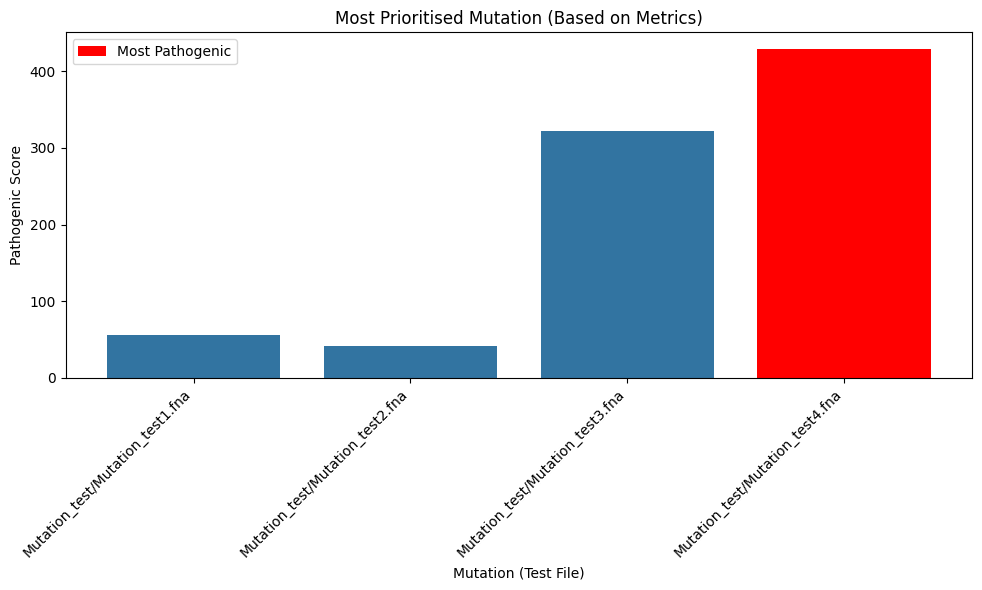

Most Pathogenic Mutation:
File: Mutation_test/Mutation_test4.fna
Score: 429.4
Reasons based on feature scores:
BLOSUM62: 1048.0
Grantham Distance: 575.0
Pathogenicity: 0
Pathogenicity scores for test files:
Pathogenicity score for Mutation_test\Mutation_test1.fna: 0.7986
Pathogenicity score for Mutation_test\Mutation_test2.fna: 0.7886
Pathogenicity score for Mutation_test\Mutation_test3.fna: 0.7916
Pathogenicity score for Mutation_test\Mutation_test4.fna: 0.7909


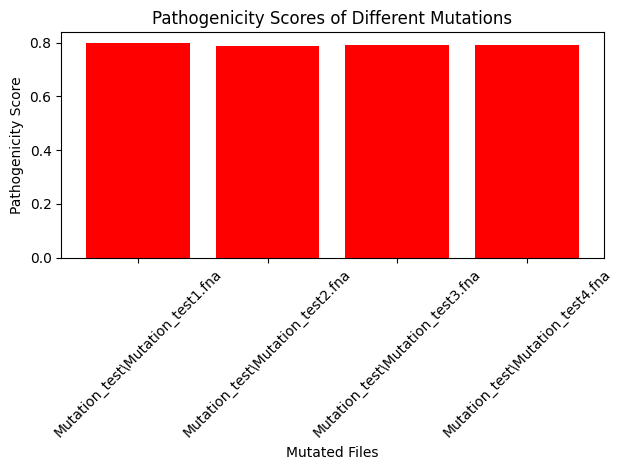

In [18]:
if __name__ == "__main__":
    original_file = 'gene_DNA_Assembly_GRCh38.fna'
    original_seq = read_fna(original_file)
    
    mutated_files = [f"Mutation_train/Mutation_train{i}.fna" for i in range(1, 17)]
    test_files = [
        "Mutation_test/Mutation_test1.fna",
        "Mutation_test/Mutation_test2.fna",
        "Mutation_test/Mutation_test3.fna",
        "Mutation_test/Mutation_test4.fna"
    ]
    
    results = map_and_extract(original_seq, mutated_files)
    
    X_sequences = [features['original_sequence'] for features in results]
    y_labels = [features.get('Target', 0) for features in results]
    
    char_to_int = create_char_to_int_mapping()
    
    X_lstm, y_lstm = prepare_data_for_lstm(X_sequences, y_labels, char_to_int)
    X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_lstm, y_lstm, test_size=0.2, random_state=7)
    
    lstm_model = train_lstm(X_train_lstm, y_train_lstm)
    
    X_cnn, y_cnn = prepare_data_for_cnn(results)
    X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(X_cnn, y_cnn, test_size=0.2, random_state=7)
    
    cnn_model = train_cnn(X_train_cnn, y_train_cnn)
    
    prioritized_results = prioritize_mutations(results)
    
    print("Prioritized Mutations:")
    for result in prioritized_results:
        print(result)
    
    
    most_pathogenic_mutation = evaluate_and_plot_mutations(original_seq, test_files)
    
    mutated_files = [
        r'Mutation_test\Mutation_test1.fna',
        r'Mutation_test\Mutation_test2.fna',
        r'Mutation_test\Mutation_test3.fna',
        r'Mutation_test\Mutation_test4.fna'
    ]
    
    results = process_mutated_files(original_file, mutated_files)
    
    print("Pathogenicity scores for test files:")
    for mutated_file, score in results.items():
        print(f"Pathogenicity score for {mutated_file}: {score:.4f}")
    
    visualize_results(results)

    if "Mutation_test/Mutation_test4.fna" in results:
        print(f"Pathogenicity score for Mutation_test\\Mutation_test4.fna: {results['Mutation_test/Mutation_test4.fna']:.4f}")